In [1]:
!pip install yfinance
!pip install talib

ERROR: Could not find a version that satisfies the requirement talib
ERROR: No matching distribution found for talib


In [2]:
import yfinance as yf # to download the data from yahoo finance
import numpy as np # for numerical operations
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for data visualisation
%matplotlib inline
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import matplotlib.colors as clrs
from datetime import datetime, timedelta # for operations related to datetime objects
import talib as ta # Technical analysis library
from statsmodels.tsa.stattools import adfuller # augmented dickey fuller test for stationarity of time series 
from sklearn.model_selection import train_test_split #For spliting the data to Train and Test Data
# Import sklearn's Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# Libraries for evaluating the model
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
ticker = "^NSEI" # for nifty 50 index
end = datetime.today() # to record todays date
years = 25
start = end - timedelta(days = 365*years) # to record date of 25 years in the past

In [4]:
nifty = yf.download(ticker,start,end) # downloading data for nifty 50 for 10 years
nifty.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0


In [5]:
#removing the volume column as there is no volume in nifty 50 index
nifty.drop('Volume', inplace=True, axis=1)
nifty.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805


In [6]:
# As we are taking adj close into consideration for ML Model we have to adjust the Open, Low and High prices as well.
# Reason for taking adj close:- Adj Close takes corporate events like split, bonus, divedend etc into consideration

nifty['Adj factor']  = nifty['Adj Close']/nifty['Close'] # Calculating Adjusting Factor
nifty['Adj Open'] = nifty['Adj factor'] * nifty['Open'] # Multiplying Open with adjusting factor
nifty['Adj High'] = nifty['Adj factor'] * nifty['High'] # Multiplying High with adjusting factor
nifty['Adj Low'] = nifty['Adj factor'] * nifty['Low'] # Multiplying Low with adjusting factor
nifty.head()

,Open,High,Low,Close,Adj Close,Adj factor,Adj Open,Adj High,Adj Low
Date,,,,,,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,1.0,4518.450195,4549.049805,4482.850098
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,1.0,4494.100098,4551.799805,4481.549805
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,1.0,4550.250000,4739.000000,4550.250000
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,1.0,4734.850098,4760.850098,4721.149902
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,1.0,4752.950195,4855.700195,4733.700195


##  Plotting Adj Close Price

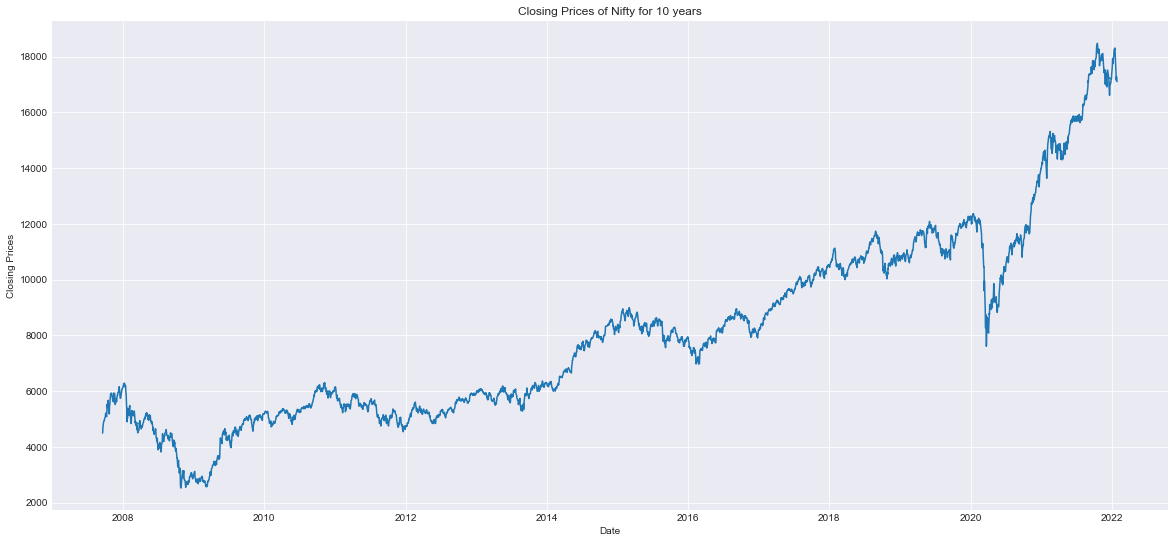

In [7]:
plt.rcParams["figure.figsize"] = (20,9) #plotting clossing prices for nifty
plt.plot(nifty['Adj Close'])
plt.title("Closing Prices of Nifty for 10 years")
plt.xlabel("Date")
plt.ylabel("Closing Prices")
plt.grid(True)
plt.show()

## Setting up a Target Variable

Target variable is what the machine learning model tries to predict in order to solve the problem statement.

In [8]:
nifty['change'] = nifty['Adj Close'].pct_change().shift(-1) # Calculating todays % change from perv days

#Creating a signal column.also our Target
nifty['signal'] = np.where(nifty['change'] > 0, 1, 0)
nifty.head()

,Open,High,Low,Close,Adj Close,Adj factor,Adj Open,Adj High,Adj Low,change,signal
Date,,,,,,,,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,1.0,4518.450195,4549.049805,4482.850098,0.011469,1
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,1.0,4494.100098,4551.799805,4481.549805,0.040946,1
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,1.0,4550.250000,4739.000000,4550.250000,0.003212,1
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,1.0,4734.850098,4760.850098,4721.149902,0.018957,1
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,1.0,4752.950195,4855.700195,4733.700195,0.019566,1


## Features
In order to predict the target, we will need the input variable also called as Features

In [9]:
nifty['rsi'] = ta.RSI(nifty['Adj Close'].values, timeperiod=3) #Calculating Relative Strength Indicator for 3 days period
# RSI is a relative strength indicator which tells us if underlying is overbought or oversold
nifty['adx'] = ta.ADX(nifty['Adj High'].values,nifty['Adj Low'].values,
                     nifty['Adj Open'].values,timeperiod=5)
nifty['moving_avg'] = nifty['Adj Close'].rolling(window=9).mean()
nifty.head()

,Open,High,Low,Close,Adj Close,Adj factor,Adj Open,Adj High,Adj Low,change,signal,rsi,adx,moving_avg
Date,,,,,,,,,,,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,1.0,4518.450195,4549.049805,4482.850098,0.011469,1,NaN,NaN,NaN
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,1.0,4494.100098,4551.799805,4481.549805,0.040946,1,NaN,NaN,NaN
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,1.0,4550.250000,4739.000000,4550.250000,0.003212,1,NaN,NaN,NaN
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,1.0,4734.850098,4760.850098,4721.149902,0.018957,1,100.0,NaN,NaN
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,1.0,4752.950195,4855.700195,4733.700195,0.019566,1,100.0,NaN,NaN


In [10]:
# Calculating Correlation of Adj Close with Moving average for 9 periods
nifty['corr'] = nifty['Adj Close'].rolling(window=9).corr(nifty['moving_avg'])
nifty.head()

,Open,High,Low,Close,Adj Close,Adj factor,Adj Open,Adj High,Adj Low,change,signal,rsi,adx,moving_avg,corr
Date,,,,,,,,,,,,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,1.0,4518.450195,4549.049805,4482.850098,0.011469,1,NaN,NaN,NaN,NaN
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,1.0,4494.100098,4551.799805,4481.549805,0.040946,1,NaN,NaN,NaN,NaN
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,1.0,4550.250000,4739.000000,4550.250000,0.003212,1,NaN,NaN,NaN,NaN
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,1.0,4734.850098,4760.850098,4721.149902,0.018957,1,100.0,NaN,NaN,NaN
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,1.0,4752.950195,4855.700195,4733.700195,0.019566,1,100.0,NaN,NaN,NaN


In [11]:
# Lets calculate the volatility of nifty
nifty['volatility'] = nifty.rolling(5)['change'].std()*100 # Calculating volatility for 1 week
nifty['volatility2'] = nifty.rolling(10)['change'].std()*100 # calculating volatity for 2 weeks
nifty.tail()

,Open,High,Low,Close,Adj Close,Adj factor,Adj Open,Adj High,Adj Low,change,signal,rsi,adx,moving_avg,corr,volatility,volatility2
Date,,,,,,,,,,,,,,,,,
2022-01-21,17613.699219,17707.599609,17485.849609,17617.150391,17617.150391,1.0,17613.699219,17707.599609,17485.849609,-0.026568,0,8.067283,50.618590,18057.261285,-0.321997,0.767235,1.024288
2022-01-24,17575.150391,17599.400391,16997.849609,17149.099609,17149.099609,1.0,17575.150391,17599.400391,16997.849609,0.007513,1,3.080142,56.467505,17956.522352,-0.100070,1.207966,1.072004
2022-01-25,17001.550781,17309.150391,16836.800781,17277.949219,17277.949219,1.0,17001.550781,17309.150391,16836.800781,-0.009712,0,22.789848,61.788670,17852.700087,0.435474,1.208014,0.977487
2022-01-27,17062.000000,17182.500000,16866.750000,17110.150391,17110.150391,1.0,17062.000000,17182.500000,16866.750000,-0.000479,0,16.310496,66.045602,17725.183377,0.731274,1.268152,0.952354
2022-01-28,17208.300781,17373.500000,17077.099609,17101.949219,17101.949219,1.0,17208.300781,17373.500000,17077.099609,NaN,0,15.977471,61.101302,17596.983290,0.794791,NaN,NaN


In [12]:
#we encountered NaN in first 3 rows in RSI and NaN in first 5 rows because it take 3 period calculation for RSI and 5 period \
# calculation for ADX,and 9 period calculation for moving average. Hence we dropped the 9 rows with NaN Values
nifty.dropna(axis=0,inplace=True)
nifty.head()

,Open,High,Low,Close,Adj Close,Adj factor,Adj Open,Adj High,Adj Low,change,signal,rsi,adx,moving_avg,corr,volatility,volatility2
Date,,,,,,,,,,,,,,,,,
2007-10-10,5328.149902,5454.700195,5328.149902,5441.450195,5441.450195,1.0,5328.149902,5454.700195,5328.149902,0.015327,1,85.456388,70.180717,5172.216688,0.856711,2.561607,1.855485
2007-10-11,5438.899902,5532.750000,5424.250000,5524.850098,5524.850098,1.0,5438.899902,5532.750000,5424.250000,-0.017485,0,89.228298,68.890990,5230.472276,0.887049,2.826009,2.066696
2007-10-12,5525.299805,5549.299805,5402.600098,5428.250000,5428.250000,1.0,5525.299805,5549.299805,5402.600098,0.044609,1,61.511251,65.757410,5275.683377,0.859772,2.631999,2.350215
2007-10-15,5428.350098,5682.649902,5419.899902,5670.399902,5670.399902,1.0,5428.350098,5682.649902,5419.899902,-0.000414,0,82.246876,66.344663,5342.511122,0.886511,2.336950,2.384799
2007-10-16,5670.649902,5708.350098,5578.450195,5668.049805,5668.049805,1.0,5670.649902,5708.350098,5578.450195,-0.019186,0,81.606842,67.276524,5393.316678,0.929691,2.643137,2.486553


## Creating X and y
Target is denoted by **y** and Features are denoted by **X**

The target that we need is nifty['signal'].
The features that we need are nifty['future_returns', 'rsi','adx', 'moving_avg', 'corr', 'volatility', 'volatility2']

In [13]:
y = nifty[['signal']].copy()
X = nifty[['change','rsi','adx', 'moving_avg', 'corr', 'volatility', 'volatility2']].copy()

## Lets Check for stationarity
As stationarity is important for most of the ML algorithms, we will drop non-stationary columns for X \
adfuller test checks for stationarity

In [14]:
def stationary(series):
    """Function to check if the series is stationary or not.
    """

    result = adfuller(series)
    if(result[1] < 0.05):
        return 'stationary'
    else:
        return 'not stationary'


# Check for stationarity
for col in X.columns:
    if stationary(nifty[col]) == 'not stationary':
        print('%s is not stationary. Dropping it.' % col)
        X.drop(columns=[col], axis=1, inplace=True)
    else:
        print('%s is stationary.' % col)

change is stationary.
rsi is stationary.
adx is stationary.
moving_avg is not stationary. Dropping it.
corr is stationary.
volatility is stationary.
volatility2 is stationary.


In [15]:
X.head() #Moving average has been dropped as it was not stationary.

,change,rsi,adx,corr,volatility,volatility2
Date,,,,,,
2007-10-10,0.015327,85.456388,70.180717,0.856711,2.561607,1.855485
2007-10-11,-0.017485,89.228298,68.890990,0.887049,2.826009,2.066696
2007-10-12,0.044609,61.511251,65.757410,0.859772,2.631999,2.350215
2007-10-15,-0.000414,82.246876,66.344663,0.886511,2.336950,2.384799
2007-10-16,-0.019186,81.606842,67.276524,0.929691,2.643137,2.486553


## Correlation Check
Checking the correlation between features. \
If any 2 features have more than 0.7 correlation we will drop either of the features

In [16]:
def get_pair_above_threshold(X, threshold):
    """Function to return the pairs with correlation above threshold.
    """
    # Calculate the correlation matrix
    correl = X.corr()

    # Unstack the matrix
    correl = correl.abs().unstack()

    # Recurring & redundant pair
    pairs_to_drop = set()
    cols = X.corr().columns
    for i in range(0, X.corr().shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))

    # Drop the recurring & redundant pair
    correl = correl.drop(labels=pairs_to_drop).sort_values(ascending=False)

    return correl[correl > threshold].index


print(get_pair_above_threshold(X, 0.7))

MultiIndex([('volatility', 'volatility2')],
           )


In [17]:
X = X.drop(columns=['volatility2'], axis=1)
X.head() # Displaying the final features

,change,rsi,adx,corr,volatility
Date,,,,,
2007-10-10,0.015327,85.456388,70.180717,0.856711,2.561607
2007-10-11,-0.017485,89.228298,68.890990,0.887049,2.826009
2007-10-12,0.044609,61.511251,65.757410,0.859772,2.631999
2007-10-15,-0.000414,82.246876,66.344663,0.886511,2.336950
2007-10-16,-0.019186,81.606842,67.276524,0.929691,2.643137


In [18]:
y.head(), X.head()

(            signal
 Date              
 2007-10-10       1
 2007-10-11       0
 2007-10-12       1
 2007-10-15       0
 2007-10-16       0,
               change        rsi        adx      corr  volatility
 Date                                                            
 2007-10-10  0.015327  85.456388  70.180717  0.856711    2.561607
 2007-10-11 -0.017485  89.228298  68.890990  0.887049    2.826009
 2007-10-12  0.044609  61.511251  65.757410  0.859772    2.631999
 2007-10-15 -0.000414  82.246876  66.344663  0.886511    2.336950
 2007-10-16 -0.019186  81.606842  67.276524  0.929691    2.643137)

In [19]:
# Obtain the features and target for the `train_data` and `test_data`
# The features (X) and the target (y) is passed along with the size of the train_data as a percentage of the total data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75,shuffle=False)
#shuffle has been set to false because this data is time series data, if the shuffle is kept true then the data wont make any,
#sense.

# Print the dimensions of the variables
print(f"The shape of the X variable is {X.shape}.")
print(f"The shape of the y variable is {y.shape}. \n")
print(f"The shape of the X_train variable is {X_train.shape}.")
print(f"The shape of the y_train variable is {y_train.shape}.\n")
print(f"The shape of the X_test variable is {X_test.shape}.")
print(f"The shape of the y_test variable is {y_test.shape}.\n")

The shape of the X variable is (3500, 5).
The shape of the y variable is (3500, 1). 

The shape of the X_train variable is (2625, 5).
The shape of the y_train variable is (2625, 1).

The shape of the X_test variable is (875, 5).
The shape of the y_test variable is (875, 1).



## Visualise the Data

Let's plot one of the columns of the features to see how the data is split.

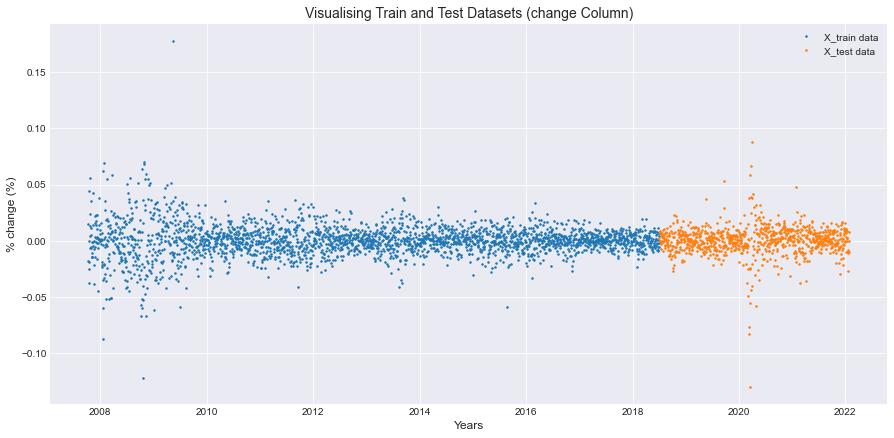

In [20]:
# Plot the data
plt.figure(figsize=(15, 7))

plt.plot(X_train['change'], linestyle='None',
         marker='.', markersize=3.0, label='X_train data')
plt.plot(X_test['change'], linestyle='None',
         marker='.', markersize=3.0, label='X_test data')

# Set the title and axis label
plt.title("Visualising Train and Test Datasets (change Column)", fontsize=14)
plt.xlabel('Years', fontsize=12)
plt.ylabel('% change (%)', fontsize=12)

# Display the plot
plt.legend()
plt.show()

In [21]:
# X_train.to_csv("../My python/nifty_X_train.csv")
# X_test.to_csv("../My python/nifty_X_test.csv")
# y_train.to_csv("../My python/nifty_y_train.csv")
# y_test.to_csv("../My python/nifty_y_test.csv")

In [22]:
print(f"The shape of the X variable is {X.shape}.")
print(f"The shape of the y variable is {y.shape}. \n")
print(f"The shape of the X_train variable is {X_train.shape}.")
print(f"The shape of the y_train variable is {y_train.shape}.\n")
print(f"The shape of the X_test variable is {X_test.shape}.")
print(f"The shape of the y_test variable is {y_test.shape}.\n")

The shape of the X variable is (3500, 5).
The shape of the y variable is (3500, 1). 

The shape of the X_train variable is (2625, 5).
The shape of the y_train variable is (2625, 1).

The shape of the X_test variable is (875, 5).
The shape of the y_test variable is (875, 1).



In [23]:
# Create the machine learning model
rf_model = RandomForestClassifier(
    n_estimators=3, max_features=3, max_depth=2, random_state=4)

In [24]:
rf_model.fit(X_train, y_train['signal'])

RandomForestClassifier(max_depth=2, max_features=3, n_estimators=3,
                       random_state=4)

In [25]:
# Get a sample day of data from X_test
unseen_data_single_day = X_test.head(1)

# Preview the data
unseen_data_single_day #This shows the data for 8th Aug, 2019

,change,rsi,adx,corr,volatility
Date,,,,,
2018-07-05,0.00213,60.878158,25.815862,0.190125,0.472005


In [26]:
# Get the prediction of a single day
single_day_prediction = rf_model.predict(unseen_data_single_day) 

# Preview the prediction
single_day_prediction #The prediction for 4th July,2018 was to not to go long on Nifty

array([1])

In [27]:
# Use the model and predict the values for the test data
y_pred = rf_model.predict(X_test)

# Display the first five predictions
print("The first five predicted values", y_pred[:5])

The first five predicted values [1 1 1 1 1]


In [34]:
y_pred = pd.Series(y_pred)
y_pred

0      1
1      1
2      1
3      1
4      1
      ..
870    0
871    0
872    1
873    0
874    0
Length: 875, dtype: int32

The model predictions are stored in y_pred. 0 means no position and 1 means a long position. With the y_pred we can now place trades using an ML model.

In [36]:
predicted_signal = pd.DataFrame(y_pred, index=y_test.index, columns=['signal'])

## ML Models Evaluation Metrics

In [30]:
# # Define the path for the data files
# path = "../My python/"

# # Read the model predicted target values
# y_pred = pd.read_csv(path + "nifty_predicted_signals.csv",
#                      index_col=0, parse_dates=True)['signal']

# # Read the target values of the testing dataset
# y_test = pd.read_csv(path + "nifty_y_test.csv",
#                      index_col=0, parse_dates=True)['signal']

In [37]:
y_test

,signal
Date,
2018-07-05,1
2018-07-06,1
2018-07-09,1
2018-07-10,1
2018-07-11,1
...,...
2022-01-20,0
2022-01-21,0
2022-01-24,1


In [48]:
accuracy_data['signal'].unique()

array([False])

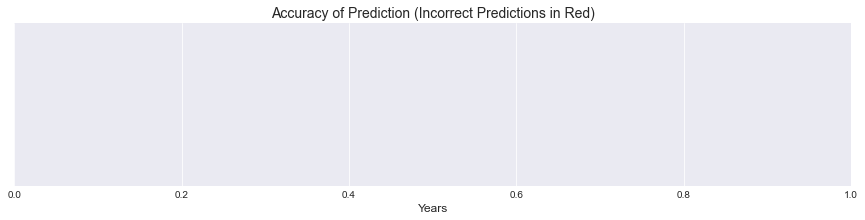

The accuracy is signal    0.0
dtype: float64%.


In [43]:
# define Accuracy
accuracy_data = (predicted_signal == y_test)

# Accuracy percentage
accuracy_percentage = round(100 * accuracy_data.sum()/len(accuracy_data), 2)

# Plot the accuracy data
plt.figure(figsize=(15, 3))

# Colour mapping for the correct and incorrect predictions
cmap = clrs.ListedColormap(['green', 'red'])

plt.yticks([])
 plt.scatter(x=y_test.index, y=[1]*len(y_test),
              c=(accuracy_data != True).astype(float), marker='.', cmap=cmap)

# Set the title and axis label
plt.title("Accuracy of Prediction (Incorrect Predictions in Red)", fontsize=14)
plt.xlabel('Years', fontsize=12)

# Display the results
plt.show()
print(f"The accuracy is {accuracy_percentage}%.")